## Import Libraries

In [67]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## Display Settings

In [5]:
pd.set_option("display.max_columns",None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

## Read The Data

In [6]:
project_dir="/home/spynom/project/flights_sageaker_project"
data_dir="data"

In [10]:
def get_data(filename:str)->pd.DataFrame:
    file_name=f"{filename}.csv"
    file_path= os.path.join(project_dir,data_dir,file_name)
    return pd.read_csv(file_path)

In [11]:
train=get_data("train")

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7321 entries, 0 to 7320
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          7321 non-null   object 
 1   date_of_journey  7321 non-null   object 
 2   source           7321 non-null   object 
 3   destination      7321 non-null   object 
 4   dep_time         7321 non-null   object 
 5   arrival_time     7321 non-null   object 
 6   duration         7321 non-null   int64  
 7   total_stops      7320 non-null   float64
 8   additional_info  7321 non-null   object 
 9   price            7321 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 572.1+ KB


In [14]:
X_train=train.drop(columns="price")

In [15]:
y_train=train.price

## Transformation Operations

In [16]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

**Airline**

In [17]:
X_train.airline.value_counts()

airline
Jet Airways          2595
IndiGo               1430
Air India            1168
Multiple carriers     847
SpiceJet              562
Vistara               355
Air Asia              229
GoAir                 135
Name: count, dtype: int64

In [19]:
X_train.airline.isnull().sum()

np.int64(0)

In [24]:
air_transformer= Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoding",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])
air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_IndiGo,airline_Jet Airways,airline_Multiple carriers,airline_other
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
7316,0.0,1.0,0.0,0.0,0.0
7317,0.0,0.0,1.0,0.0,0.0
7318,0.0,1.0,0.0,0.0,0.0
7319,0.0,1.0,0.0,0.0,0.0


**date_of_journey**

In [26]:
X_train.date_of_journey

0       2019-05-24
1       2019-05-18
2       2019-04-03
3       2019-04-06
4       2019-05-27
           ...    
7316    2019-06-03
7317    2019-03-21
7318    2019-04-03
7319    2019-04-27
7320    2019-06-09
Name: date_of_journey, Length: 7321, dtype: object

In [40]:
feature_to_extract= ["month","week","day_of_week","day_of_year"]
doj_transformer= Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True,format="mixed")),
    ("scaler",MinMaxScaler())
])
doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.705882,0.666667,0.711864
1,0.666667,0.647059,0.833333,0.661017
2,0.333333,0.294118,0.333333,0.279661
3,0.333333,0.294118,0.833333,0.305085
4,0.666667,0.764706,0.000000,0.737288
...,...,...,...,...
7316,1.000000,0.823529,0.000000,0.796610
7317,0.000000,0.176471,0.500000,0.169492
7318,0.333333,0.294118,0.333333,0.279661
7319,0.333333,0.470588,0.833333,0.483051


**Source & Destination**

In [41]:
location_subset=X_train.loc[:,["source","destination"]]

In [45]:
location_pip1=Pipeline(steps=[
    ("group",RareLabelEncoder(tol=0.1,replace_with="rare",n_categories=2)),
    ("encoder",MeanEncoder()),
    ("scaler",PowerTransformer())
       
])
location_pip1.fit_transform(location_subset,y_train)

,source,destination
0,-0.888381,-1.845153
1,-1.904299,-0.842241
2,-0.194239,-0.195465
3,1.041703,1.040753
4,-0.888381,-1.845153
...,...,...
7316,-0.888381,-1.845153
7317,-0.888381,-0.842241
7318,1.041703,1.040753
7319,1.041703,1.040753


In [50]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [59]:
def is_north(X):
    columns= X.columns.to_list()
    north_cities = ["Delhi","kolkata","New Delhi"]
    return (
        X.assign(**{
            f"{col}_is_north":X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        }
    ).drop(columns=columns))
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,0,0
2,0,0
3,1,0
4,0,1
...,...,...
7316,0,1
7317,0,1
7318,1,0
7319,1,0


In [61]:
location_transformer=FeatureUnion(transformer_list=[
    ("part1",location_pip1),
    ("part2",FunctionTransformer(func=is_north))
])

**dep_time** & **Arrival_time**

In [64]:
time_subset=X_train[["dep_time","arrival_time"]]

In [71]:
time_pip1=Pipeline( 
    steps=[
        ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
        ("scale",MinMaxScaler())
    ]
)
time_pip1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.478261,0.727273,0.608696,0.545455
1,0.391304,0.818182,0.521739,0.000000
2,0.434783,0.363636,0.521739,1.000000
3,0.347826,0.000000,0.826087,0.000000
4,0.695652,1.000000,0.826087,1.000000
...,...,...,...,...
7316,0.347826,0.545455,0.478261,0.363636
7317,0.304348,0.000000,0.913043,0.363636
7318,0.434783,0.636364,0.652174,0.636364
7319,0.217391,0.636364,0.347826,0.909091


In [68]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,afternoon
1,morning,afternoon
2,morning,afternoon
3,morning,evening
4,evening,evening
...,...,...
7316,morning,morning
7317,morning,night
7318,morning,afternoon
7319,morning,morning


In [69]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.670132
4,0.204762,0.670132
...,...,...
7316,1.000000,0.939509
7317,1.000000,1.000000
7318,1.000000,0.000000
7319,1.000000,0.939509


In [73]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pip1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.478261,0.727273,0.608696,0.545455,1.000000,0.000000
1,0.391304,0.818182,0.521739,0.000000,1.000000,0.000000
2,0.434783,0.363636,0.521739,1.000000,1.000000,0.000000
3,0.347826,0.000000,0.826087,0.000000,1.000000,0.670132
4,0.695652,1.000000,0.826087,1.000000,0.204762,0.670132
...,...,...,...,...,...,...
7316,0.347826,0.545455,0.478261,0.363636,1.000000,0.939509
7317,0.304348,0.000000,0.913043,0.363636,1.000000,1.000000
7318,0.434783,0.636364,0.652174,0.636364,1.000000,0.000000
7319,0.217391,0.636364,0.347826,0.909091,1.000000,0.939509


**duration**

In [78]:
train.duration.loc[train.duration.between(800,1600)].count()

np.int64(1996)

In [81]:
def type_of_dur(X:pd.DataFrame):
    return(X.assign(
       duration= np.select(
           [X.loc[:,"duration"].between(1,400,inclusive="left"),
            X.loc[:,"duration"].between(400,800,inclusive="left"),
            X.loc[:,"duration"].between(800,1600,inclusive="left")
               
           ],
           ["short","medium","long"
               
           ],
           default="extremly long"

        )
    ))
type_of_dur(X_train.loc[:,["duration"]]
            ).value_counts()

duration     
short            3113
long             1985
medium           1859
extremly long     364
Name: count, dtype: int64

In [86]:
duration_pipe1=Pipeline(steps=
    [
        ("trans_to_cat",FunctionTransformer(func=type_of_dur)),
        ("encoding",OneHotEncoder(sparse_output=False)),

    ]
)

In [87]:
duration_pipe1.fit_transform(X_train.loc[:,["duration"]])

,duration_extremly long,duration_long,duration_medium,duration_short
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
7316,0.0,0.0,0.0,1.0
7317,0.0,1.0,0.0,0.0
7318,0.0,0.0,0.0,1.0
7319,0.0,0.0,0.0,1.0


In [95]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [99]:
RBFPercentilesimilarity().fit_transform(X_train[["duration"]])

,duration_rbf_25.0,duration_rbf_50.0,duration_rbf_75.0
0,1.000000e+00,0.0,0.000000e+00
1,6.293989e-54,0.0,0.000000e+00
2,1.691898e-10,0.0,0.000000e+00
3,0.000000e+00,0.0,0.000000e+00
4,4.539993e-05,0.0,0.000000e+00
...,...,...,...
7316,1.000000e+00,0.0,0.000000e+00
7317,0.000000e+00,0.0,4.225900e-132
7318,0.000000e+00,0.0,0.000000e+00
7319,7.187782e-28,0.0,0.000000e+00


In [106]:
duration_final_pipe=Pipeline(steps=[
    ("imputer",SimpleImputer(fill_value="median")),
    ("handle_outlier",Winsorizer(capping_method="iqr",fold=1.5)),
    ("next_steps",
    FeatureUnion(transformer_list=[
    ("type_of_duration",duration_pipe1),
    ("rbf",Pipeline(steps=[
        ("convert_to_rbf",RBFPercentileSimilarity()),
        ("scaler",PowerTransformer())
    ]))
]))])

duration_final_pipe.fit_transform(X_train[["duration"]])

,duration_extremly long,duration_long,duration_medium,duration_short,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.0,0.0,0.0,1.0,3.131338,-0.10542,-0.098759
1,0.0,0.0,0.0,1.0,-0.360650,-0.10542,-0.098759
2,0.0,0.0,0.0,1.0,-0.360650,-0.10542,-0.098759
3,0.0,0.0,1.0,0.0,-0.360650,-0.10542,-0.098759
4,0.0,0.0,0.0,1.0,-0.357449,-0.10542,-0.098759
...,...,...,...,...,...,...,...
7316,0.0,0.0,0.0,1.0,3.131338,-0.10542,-0.098759
7317,0.0,1.0,0.0,0.0,-0.360650,-0.10542,-0.098759
7318,0.0,0.0,0.0,1.0,-0.360650,-0.10542,-0.098759
7319,0.0,0.0,0.0,1.0,-0.360650,-0.10542,-0.098759


**total_stops**"

In [108]:
X_train.total_stops.value_counts()

total_stops
1.0    3951
0.0    2411
2.0     931
3.0      27
Name: count, dtype: int64

In [116]:
X_train.total_stops>1

0       False
1       False
2       False
3       False
4       False
        ...  
7316    False
7317    False
7318    False
7319    False
7320    False
Name: total_stops, Length: 7321, dtype: bool

In [128]:
def is_direct(X:pd.DataFrame):
    return(X.assign(
        is_direct=np.where(X.total_stops==0,1,0)
    ))
is_direct(train.loc[:,["total_stops"]])
total_stops_pip=FunctionTransformer(func=is_direct)

**additional_information**

In [133]:
X_train.additional_info.value_counts()
additional_info=OneHotEncoder(max_categories=4,sparse_output=False)

## Final_pipline

In [139]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_final_pipe, ["duration"]),
	("stops", total_stops_pip, ["total_stops"]),
	("info", additional_info, ["additional_info"])
], remainder="passthrough")

In [140]:
column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_IndiGo,air__airline_Jet Airways,air__airline_Multiple carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_extremly long,dur__duration_long,dur__duration_medium,dur__duration_short,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,stops__total_stops,stops__is_direct,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_No check-in baggage included,info__additional_info_infrequent_sklearn
0,0.0,0.0,0.0,0.0,1.0,0.666667,0.705882,0.666667,0.711864,-0.888381,-1.845153,0,1,0.478261,0.727273,0.608696,0.545455,1.000000,0.000000,0.0,0.0,0.0,1.0,3.131338,-0.10542,-0.098759,0.0,1,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.833333,0.661017,-1.904299,-0.842241,0,0,0.391304,0.818182,0.521739,0.000000,1.000000,0.000000,0.0,0.0,0.0,1.0,-0.360650,-0.10542,-0.098759,0.0,1,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.333333,0.294118,0.333333,0.279661,-0.194239,-0.195465,0,0,0.434783,0.363636,0.521739,1.000000,1.000000,0.000000,0.0,0.0,0.0,1.0,-0.360650,-0.10542,-0.098759,0.0,1,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.833333,0.305085,1.041703,1.040753,1,0,0.347826,0.000000,0.826087,0.000000,1.000000,0.670132,0.0,0.0,1.0,0.0,-0.360650,-0.10542,-0.098759,1.0,0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,-0.888381,-1.845153,0,1,0.695652,1.000000,0.826087,1.000000,0.204762,0.670132,0.0,0.0,0.0,1.0,-0.357449,-0.10542,-0.098759,0.0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7316,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,-0.888381,-1.845153,0,1,0.347826,0.545455,0.478261,0.363636,1.000000,0.939509,0.0,0.0,0.0,1.0,3.131338,-0.10542,-0.098759,0.0,1,0.0,1.0,0.0,0.0
7317,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.888381,-0.842241,0,1,0.304348,0.000000,0.913043,0.363636,1.000000,1.000000,0.0,1.0,0.0,0.0,-0.360650,-0.10542,-0.098759,1.0,0,1.0,0.0,0.0,0.0
7318,0.0,1.0,0.0,0.0,0.0,0.333333,0.294118,0.333333,0.279661,1.041703,1.040753,1,0,0.434783,0.636364,0.652174,0.636364,1.000000,0.000000,0.0,0.0,0.0,1.0,-0.360650,-0.10542,-0.098759,1.0,0,0.0,1.0,0.0,0.0
7319,0.0,1.0,0.0,0.0,0.0,0.333333,0.470588,0.833333,0.483051,1.041703,1.040753,1,0,0.217391,0.636364,0.347826,0.909091,1.000000,0.939509,0.0,0.0,0.0,1.0,-0.360650,-0.10542,-0.098759,0.0,1,0.0,1.0,0.0,0.0


## feature selection

In [141]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

In [142]:

preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_IndiGo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_short,dur__duration_rbf_25,stops__total_stops,stops__is_direct
0,0.0,0.0,1.0,0.705882,0.711864,-0.888381,-1.845153,1.0,3.131338,0.0,1
1,0.0,0.0,1.0,0.647059,0.661017,-1.904299,-0.842241,1.0,-0.360650,0.0,1
2,0.0,0.0,1.0,0.294118,0.279661,-0.194239,-0.195465,1.0,-0.360650,0.0,1
3,0.0,1.0,0.0,0.294118,0.305085,1.041703,1.040753,0.0,-0.360650,1.0,0
4,1.0,0.0,0.0,0.764706,0.737288,-0.888381,-1.845153,1.0,-0.357449,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
7316,1.0,0.0,0.0,0.823529,0.796610,-0.888381,-1.845153,1.0,3.131338,0.0,1
7317,0.0,1.0,0.0,0.176471,0.169492,-0.888381,-0.842241,0.0,-0.360650,1.0,0
7318,1.0,0.0,0.0,0.294118,0.279661,1.041703,1.040753,1.0,-0.360650,1.0,0
7319,1.0,0.0,0.0,0.470588,0.483051,1.041703,1.040753,1.0,-0.360650,0.0,1


In [143]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(0.001365144133705624),
 'air__airline_IndiGo': np.float64(0.12607208964133051),
 'air__airline_Jet Airways': np.float64(0.18459272782571534),
 'air__airline_Multiple carriers': np.float64(0.019993002511137597),
 'air__airline_other': np.float64(0.11076824790091859),
 'doj__date_of_journey_month': np.float64(0.08467390963490458),
 'doj__date_of_journey_week': np.float64(0.1741136115463879),
 'doj__date_of_journey_day_of_week': np.float64(0.0063370066650718275),
 'doj__date_of_journey_day_of_year': np.float64(0.2163906189431091),
 'location__source': np.float64(0.12608772199090282),
 'location__destination': np.float64(0.12380789022495164),
 'location__source_is_north': np.float64(0.06275386296392742),
 'location__destination_is_north': np.float64(0.009131070750958611),
 'time__dep_time_hour': np.float64(0.010926439214383818),
 'time__dep_time_minute': np.float64(0.03065398008054206),
 'time__arrival_time_hour': np.float64(0.07603988264138468),
 'tim

In [144]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_No Info': np.float64(-1.0687406865494964e-05),
 'time__dep_time_part_of_day': np.float64(0.0006315655208709211),
 'air__airline_Air India': np.float64(0.001365144133705624),
 'dur__duration_rbf_75': np.float64(0.0013980787140927358),
 'info__additional_info_In-flight meal not included': np.float64(0.00150267565867294),
 'dur__duration_rbf_50': np.float64(0.0026583300429929477),
 'doj__date_of_journey_day_of_week': np.float64(0.0063370066650718275),
 'location__destination_is_north': np.float64(0.009131070750958611),
 'time__dep_time_hour': np.float64(0.010926439214383818),
 'air__airline_Multiple carriers': np.float64(0.019993002511137597),
 'dur__duration_extremly long': np.float64(0.0201855777946031),
 'info__additional_info_infrequent_sklearn': np.float64(0.028523218750426443),
 'time__dep_time_minute': np.float64(0.03065398008054206),
 'time__arrival_time_part_of_day': np.float64(0.031617611155238236),
 'time__arrival_time_minute': np.float64(0.0317776489198

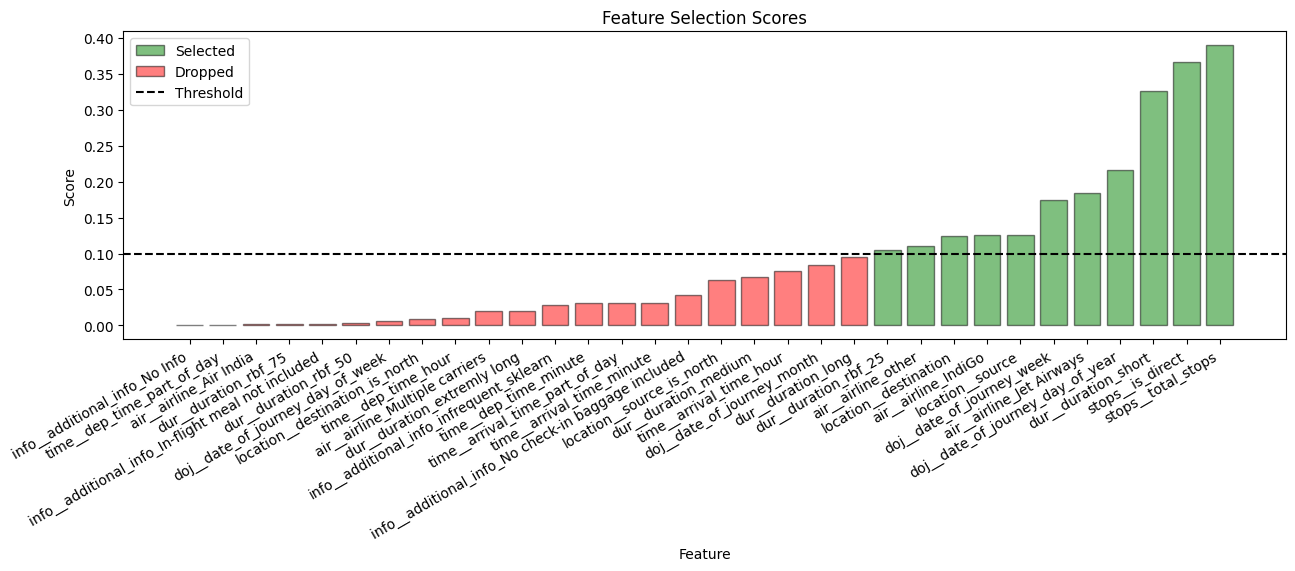

In [145]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

## export data

In [153]:
def transform_export(dataset_name:str):
    df=get_data(dataset_name)
    y=df[["price"]]
    
    pd.concat([preprocessor.transform(df.drop(columns=["price"])),y],axis=1).to_csv(f"{os.path.join(project_dir,data_dir,dataset_name)}_final.csv")

In [156]:
transform_export("test")
transform_export("train")
transform_export("val")